In [1]:
import numpy as np # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
fs = 256
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
from CogBeacon_PlotUtils import *
from CogBeaconDataset import CogBeaconDataset

cogbeacon_root_path = '/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/CogFatigueData/CogBeacon/'
dataset = CogBeaconDataset(cogbeacon_root_path)

In [2]:

def groupByfatigueLevel(data, labels):
    grouped_data = defaultdict(list)
    for index, label in enumerate(labels):
        grouped_data[label].append(data[index])
    return grouped_data
           
def loadData(user_id = [1], session_day = ['First'], game_mode=['m'] , channel = "AF7"):
    # user_id = [str(i) for i in range(20) if i not in (8, 18)] 
    eegData=[]
    fatigueLabels = []
    for session in session_day:
        for user in user_id:
            for mode in game_mode:
                participant_data_per_turn , participant_labels = dataset.load_session_by_participant(user, session,mode,channel)
                eegData.append(participant_data_per_turn)
            fatigueLabels.append(participant_labels)
    return  eegData , fatigueLabels 



In [ ]:

def find_transitions_and_calc_Dq(eeg_data, label_array, window_size, x_window_count=1):
    """
    Finds transition points in the label array and calculates calc_Dq for x number of windows
    before and after each transition point for ONE subject.

    Args:
        eeg_data (list of arrays): 2D array (number_turn * eeg_recordings_in_each_turn), 
                                   each sub-array can have different lengths.
        label_array (list of int): 1D array of labels, where transitions occur.
        window_size (int): The size of the window for calculating Dq.
        calc_Dq (function): The function that calculates Dq for a given window of EEG data.
        x_window_count (int): Number of windows before and after the transition to calculate Dq for.

    Returns:
        results (list): A list of dictionaries with transition point and Dq results.
    """
    transitions = []
    results = []

    # Find transitions
    for i in range(1, len(label_array)):
        if label_array[i] != label_array[i-1]:
            transitions.append(i)

    # Calculate Dq for x windows before and after each transition
    for transition in transitions:
        dq_before_list = []
        dq_after_list = []

        for x in range(1, x_window_count + 1):
            # Define start and end for before transition window
            start_before = max(0, transition - x * window_size)
            end_before = transition - (x - 1) * window_size
            if start_before < end_before:  # To ensure valid range
                eeg_before = np.concatenate(eeg_data[start_before:end_before])
                print("------ Before transition ------ ", transition)
                dq_before,q = mfda_features(eeg_before)
                dq_before_list.append(dq_before)
        for x in range(1, x_window_count + 1):
            # Define start and end for after transition window
            start_after = transition + (x - 1) * window_size
            end_after = min(len(eeg_data), transition + x * window_size)
            if start_after < end_after:  # To ensure valid range
                eeg_after = np.concatenate(eeg_data[start_after:end_after])
                print("------ After transition ------ ", transition)
                dq_after,q = mfda_features(eeg_after)
                dq_after_list.append(dq_after)

        # Collect the results for this transition point
        results.append({
            'transition_point': transition,
            'label_before': label_array[transition-1],
            'label_after': label_array[transition],
            'Dq_before_windows': dq_before_list,
            'Dq_after_windows': dq_after_list,
            'q':q
        })

    return results

def find_transitions_and_calc_mfda_multi_subjects(all_eeg_data, all_label_arrays, window_size, x_window_count=1):
    """
    Finds transition points for each subject and calculates the average mfda_features across all subjects
    for each transition point for all subjects.

    Args:
        all_eeg_data (list of list of arrays): A list where each element is the EEG data for a subject (number_turn * eeg_recordings_in_each_turn).
        all_label_arrays (list of lists): A list where each element is the label array for a subject.
        window_size (int): The size of the window for calculating mfda_features.
        mfda_features (function): The function that calculates features for a given window of EEG data.
        x_window_count (int): Number of windows before and after the transition to calculate features for.

    Returns:
        avg_results (dict): A dictionary containing the averaged mfda features before and after transitions for all subjects.
    """
    all_features_before = {}
    all_features_after = {}

    for eeg_data, label_array in zip(all_eeg_data, all_label_arrays):
        # For each subject, find transition points
        transitions = []
        for i in range(1, len(label_array)):
            if label_array[i] != label_array[i-1]:
                transitions.append((i, label_array[i-1], label_array[i]))  # (index, from_label, to_label)

        # Calculate features for each transition
        for transition_index, from_label, to_label in transitions:
            # Calculate before transition points
            for x in range(1, x_window_count + 1):
                start_before = max(0, transition_index - x * window_size)
                end_before = transition_index - (x - 1) * window_size
                if start_before < end_before:
                    eeg_before = np.concatenate(eeg_data[start_before:end_before])
                    features_before,q = mfda_features(eeg_before, False)
                    transition_key = f'{from_label} to {to_label}'
                    if transition_key not in all_features_before:
                        all_features_before[transition_key] = []
                    all_features_before[transition_key].append(features_before)

            # Calculate after transition points
            for x in range(1, x_window_count + 1):
                start_after = transition_index + (x - 1) * window_size
                end_after = min(len(eeg_data), transition_index + x * window_size)
                if start_after < end_after:
                    eeg_after = np.concatenate(eeg_data[start_after:end_after])
                    features_after,q= mfda_features(eeg_after, False)
                    if transition_key not in all_features_after:
                        all_features_after[transition_key] = []
                    all_features_after[transition_key].append(features_after)

 

    avg_before_features = {key: np.mean(features, axis=0) if features else None for key, features in all_features_before.items()}
    avg_after_features = {key: np.mean(features, axis=0) if features else None for key, features in all_features_after.items()}

    avg_results = {
        'avg_mfda_before_windows': avg_before_features,
        'avg_mfda_after_windows': avg_after_features,
        'q':q
    }

    return avg_results


In [41]:
eegData , fatigueLabels = loadData(user_id=[str(i) for i in range(0,19) if i not in (12, 18)],channel="TP10",game_mode='m')

session loaded successfully {'user_id': '0', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 80
session loaded successfully {'user_id': '3', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '4', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '5', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120
session loaded successfully {'user_id': '6', 's

In [50]:
%load_ext autoreload
%autoreload 2

def mfda_features(X,plot=False, scaleRange=[1,7]):
    dwt, lwt = mfa.mf_analysis_full(X,
    scaling_ranges=[scaleRange],
    q = build_q_log(1,10,10),
    # q=[2,4,8,16,32,64,128],
    # q =list(range(-20,20)),
    n_cumul=2,
    p_exp=np.inf,
    gamint=0,
    weighted=None)
    q =  build_q_log(1,10,10)
    # q =list(range(-20,20)),
    dwt_sf, dwt_cumul, dwt_mfs, hmin = lwt
    return dwt_mfs.Dq , q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
transition_features = find_transitions_and_calc_mfda_multi_subjects(eegData , fatigueLabels,50)

{'0 to 1': [array([[[-0.44536688]],

       [[-0.26863001]],

       [[-0.07519842]],

       [[ 0.13523314]],

       [[ 0.41624304]],

       [[ 0.72205072]],

       [[ 0.91503146]],

       [[ 0.94696283]],

       [[ 0.99397282]],

       [[ 1.0171932 ]],

       [[ 1.0195875 ]],

       [[ 1.        ]],

       [[ 1.04815277]],

       [[ 1.07532968]],

       [[ 1.11076539]],

       [[ 1.13793367]],

       [[ 1.14848129]],

       [[ 1.17537777]],

       [[ 1.17531868]],

       [[ 1.13410115]],

       [[ 1.03691996]],

       [[ 0.87340443]],

       [[ 0.67115871]]]), array([[[-0.26453546]],

       [[-0.19035079]],

       [[-0.02311458]],

       [[ 0.18991127]],

       [[ 0.45591693]],

       [[ 0.72657862]],

       [[ 0.9022507 ]],

       [[ 0.93311646]],

       [[ 0.98098494]],

       [[ 1.00790759]],

       [[ 1.01352002]],

       [[ 1.        ]],

       [[ 1.03102449]],

       [[ 1.04132195]],

       [[ 1.04222437]],

       [[ 1.02562153]],

       [[ 1.

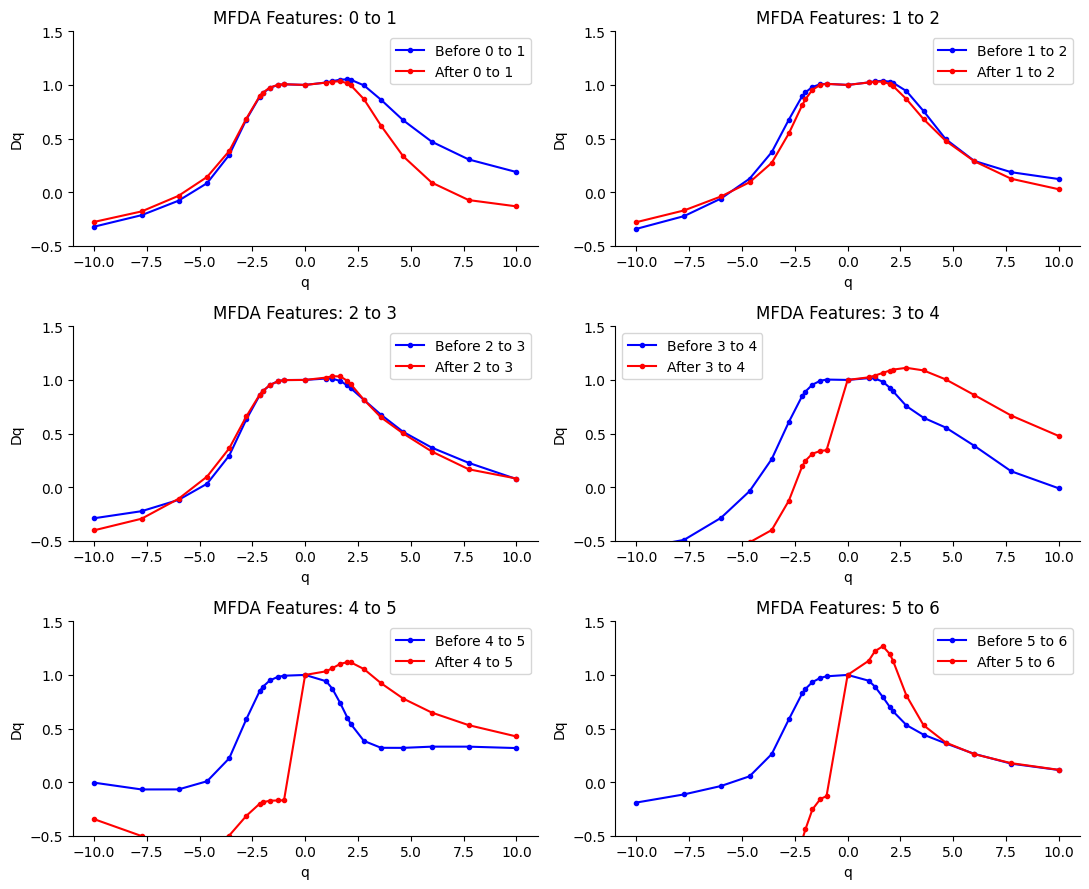

In [52]:
plot_mfda_mean_per_transition_combined(transition_features, figlabel="MFDA Features", filename_prefix="FatigueTransitions_all")

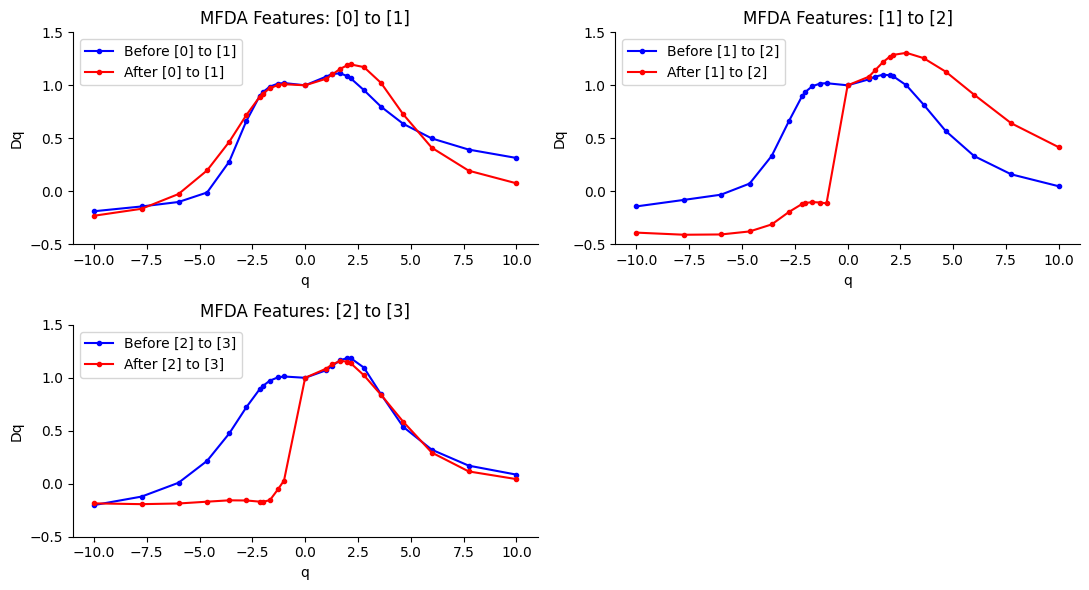

In [ ]:
plot_mfda_mean_per_transition_combined(transition_features, figlabel="MFDA Features", filename_prefix="FatigueTransitions_all")